In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models
import warnings 
warnings.filterwarnings('ignore')

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS= 50 # To save time i set 5 and codebasics was taking 50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    )

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
n_classes=len(class_names)
n_classes

3

In [6]:
len(dataset)

68

Every element in dataset is batch of 32 images, i.e why it is 68

In [7]:
32*68

2176

We have total 2152 images and after dividing into batch of 32 we get 68 batches. and last batch have less images because image count
is not multiple of 32

In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 2 1 0 1 1 1 1 0 0 2 0 1 1 0 1 1 1 0 0 0 1 0 0 0 2 1 0 1]


- `(32, 256, 256, 3)` : This show it have 32 batch of images and 256*256 is size and 3 is RGB color
- label_array:  It show 32 label of batch & class_name indicate the name

If we have to print this first image from 1st batch

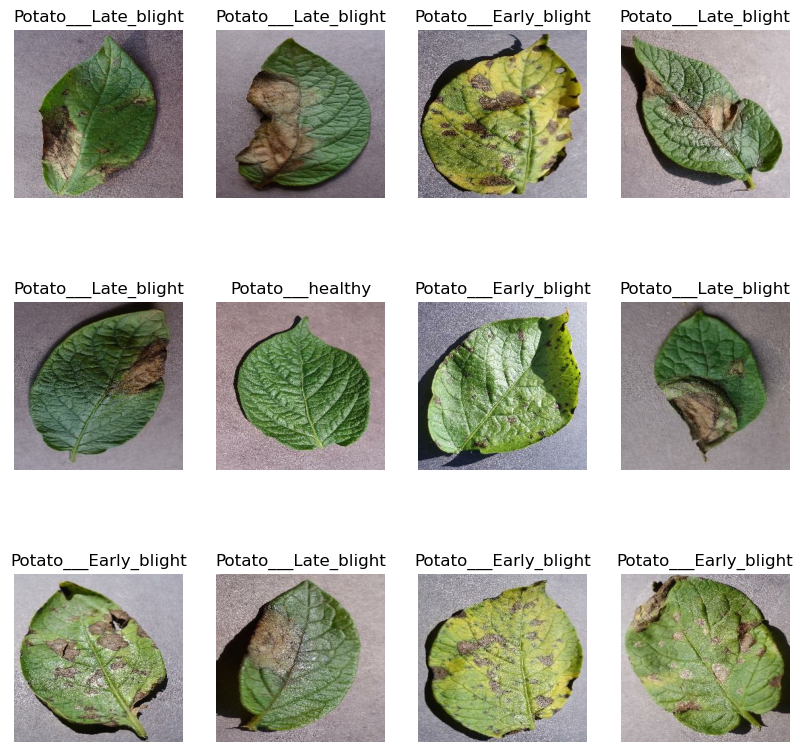

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8')) # Because the array is in float.
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

## Now we split data
- 80% : Training
- 20 % : 
    - 10% : Validation
    - 10% : Test

In [10]:
len(dataset)

68

In [11]:
train_size=0.8 # 80% train size
len(dataset)*train_size

54.400000000000006

In [12]:
train_dataset=dataset.take(54)
len(train_dataset)

54

- Now we have selected trianing dataset
-  Now we have to select remaining dataset

In [13]:
test_ds=dataset.skip(54)
len(test_ds)

14

Above test_ds is not accutual test_dataset 
- I have to again divide it into validation and test dataset

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds=test_ds.skip(6)
test_ds
len(test_ds)

8

####  Now we write a function to do all above step.
- Because all above i have done is hard coded values

In [17]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12) # seed : It is like random_state
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [18]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

Here i am just increasing the efficiency 

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE), # Resize layer
    layers.experimental.preprocessing.Rescaling(1.0/255) # Scaling layer
])

#### Here we build 2 layers of Neural Network model
- This layer is uesd to scale and resize the image

In [22]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#### Here we build 2 layers of Neural Network model
- This layer is uesd to  make model Robus and give more dataset to train.

In [23]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history=model.fit(train_ds,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1,
          validation_data=val_ds
         )



54/54 [==============================] - 136s 2s/step - loss: 0.8945 - accuracy: 0.5185 - val_loss: 0.7957 - val_accuracy: 0.5312


In [27]:
scores=model.evaluate(test_ds)
scores

8/8 [==============================] - 7s 498ms/step - loss: 0.9117 - accuracy: 0.5000


[0.911679744720459, 0.5]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 1, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

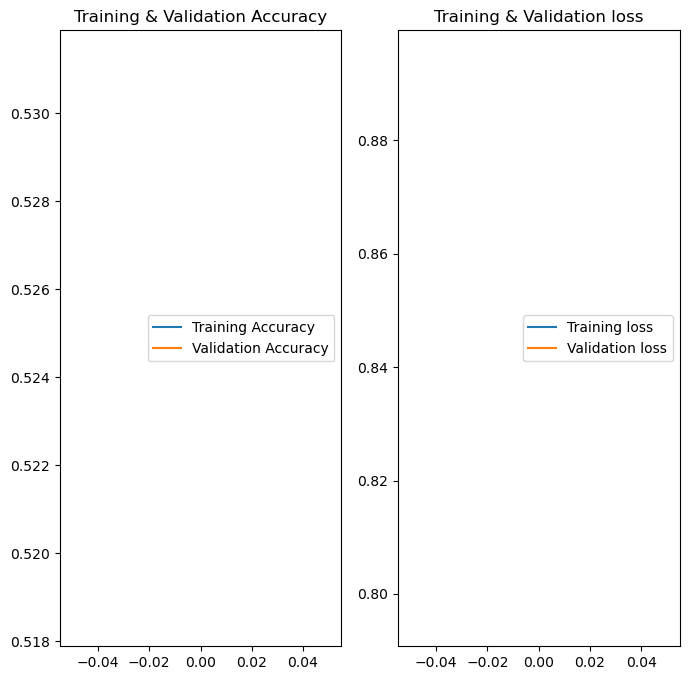

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend()
plt.title('Training & Validation loss')

plt.show()

First image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 751ms/step
predicted label: Potato___Early_blight


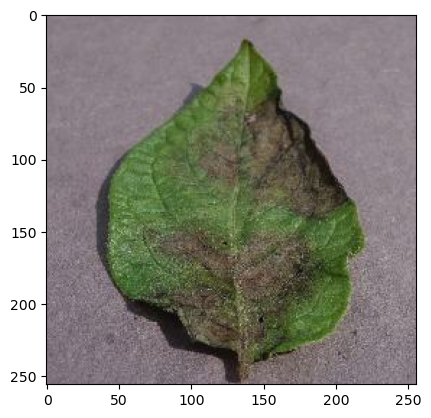

In [33]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[i].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print('predicted label:',class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model,img):
    class_names=['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
    img_array=tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array=tf.expand_dims(img_array,0) # Create a batch
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 50ms/step


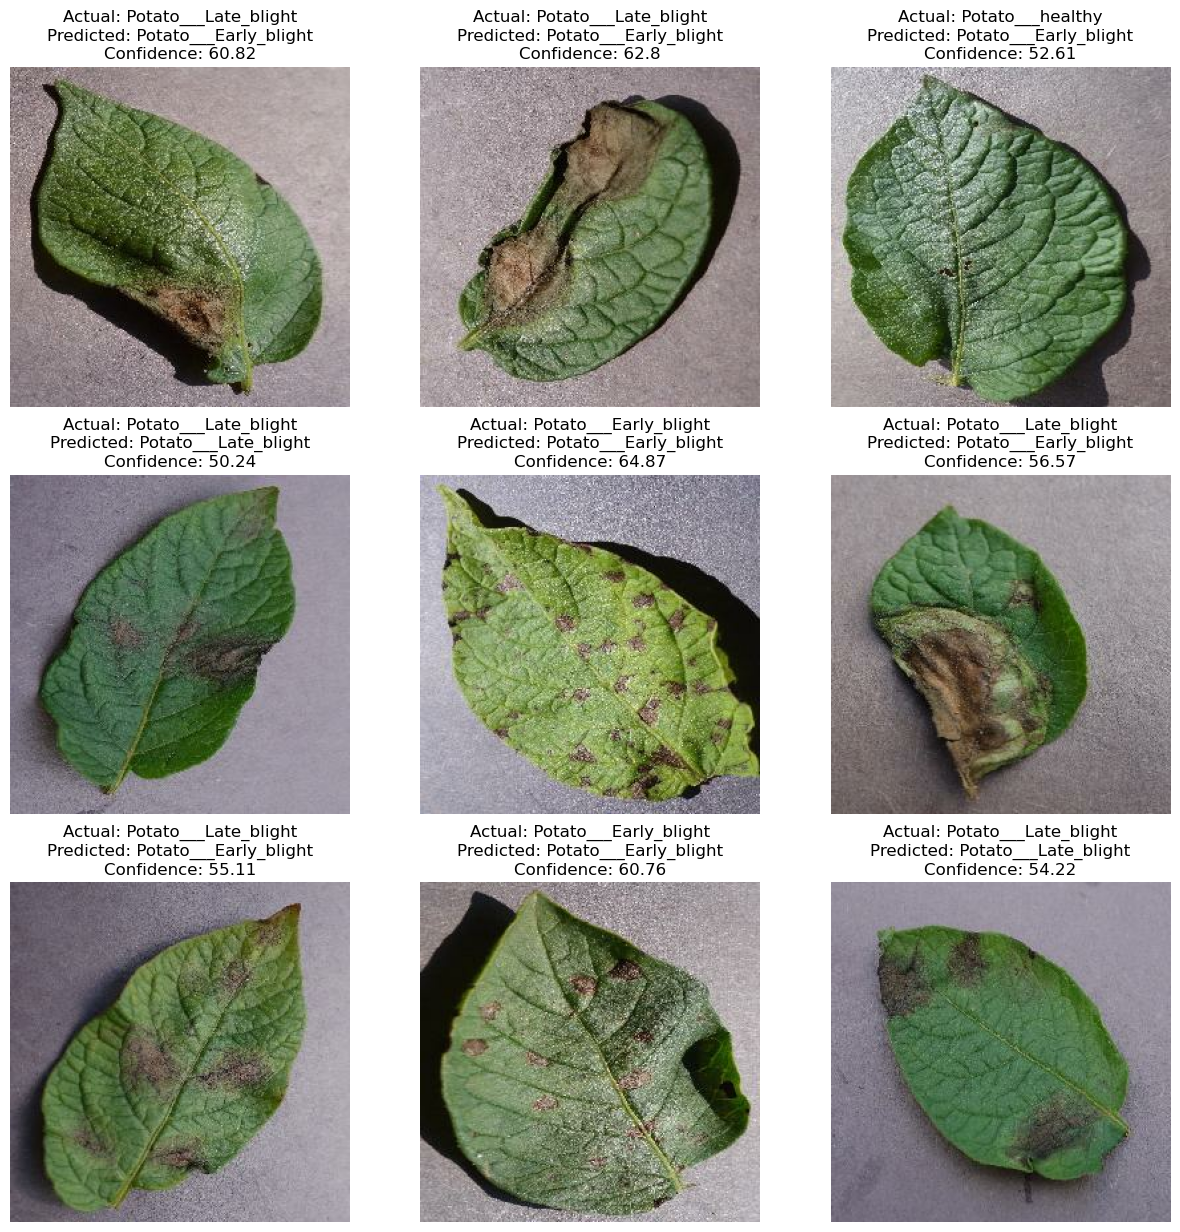

In [35]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
    
        predicted_class,confidence=predict(model,images[i])
        actual_class=class_names[labels[i]]
        plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}')
        plt.axis('off')

In [36]:
import joblib as jb
jb.dump(model,'saved_model_1.joblib')

['saved_model_1.joblib']

Save model in Joblib